## Machine Learning Models
There are 5 machine learning models that are created in this notebook. They are:
- Logistic Regression
- Random Forest
- Naive Bayes
- Support Vector Machine

Before running this file, be sure to set up the environment by following the instructions in here: [Setting Up a Python Virtual Environment](../markdown/install_instructions.md)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import seaborn as sns
import string
from wordcloud import WordCloud, get_single_color_func
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('future.no_silent_downcasting', True)

A series of functions to increase the code efficiency and readability are also created in this notebook. They are:

In [2]:
# Function to display the model results
def display_test_results(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    cf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"Test set accuracy: {accuracy:.2f}")
    print("Confusion Matrix:\n", cf_matrix)
    print("Classification Report:\n", class_report)
    
    return cf_matrix

def plot_confusion_matrix(cf_matrix, title='Confusion Matrix with Detailed Annotations', xticklabels=None, yticklabels=None):
    
    if xticklabels is None:
        xticklabels = ['Predicted Negative', 'Predicted Positive']
    if yticklabels is None:
        yticklabels = ['Actual Negative', 'Actual Positive']
    
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.set()
    plt.figure(figsize=(8, 5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', 
                xticklabels=xticklabels, yticklabels=yticklabels,
                annot_kws={"verticalalignment": 'top', "horizontalalignment": 'center'})

    plt.title(title)
    plt.xlabel('Predicted Classes')
    plt.ylabel('Actual Classes')
    plt.show()

def save_model(model, filename='model.pkl'):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {filename}")

def generate_word_clouds(df, target_column, transformed_text_column):
    colors = ['#8264be', '#f294d0', '#a6447d', '#643971', '#d092db', '#fdc3d1']
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=256)

    class SimpleGroupedColorFunc(object):
        def __init__(self, color_to_words, default_color):
            self.color_to_words = color_to_words
            self.default_color = default_color
            self.color_func_to_words = [
                (get_single_color_func(color), set(words))
                for color, words in color_to_words.items()]

        def get_color_func(self, word):
            try:
                return next(
                    color_func for (color_func, words) in self.color_func_to_words
                    if word in words)
            except StopIteration:
                return get_single_color_func(self.default_color)

        def __call__(self, word, **kwargs):
            return self.get_color_func(word)(word, **kwargs)

    def display_word_cloud(category):
        text = df[df[target_column] == category][transformed_text_column].str.cat(sep=" ")
        wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white', colormap=cmap)
        generated_wc = wc.generate(text)

        plt.figure(figsize=(15, 6))
        plt.imshow(generated_wc, interpolation='bilinear')
        plt.grid(False)
        plt.title(f'Word Cloud for {"Spam" if category else "Ham"}')
        plt.show()

    # Display word clouds for each category
    display_word_cloud(1)  # For 'spam'
    display_word_cloud(0)  # For 'ham'
    
def create_rainbow_bar_plot(corpus, title):
    counter = Counter(corpus)
    df_counter = pd.DataFrame(counter.most_common(30), columns=['Word', 'Count'])
    df_counter = df_counter.sort_values('Count', ascending=False).reset_index(drop=True)
    
    n_colors = df_counter.shape[0]
    colors = sns.color_palette("Spectral", n_colors)
    soft_rainbow = LinearSegmentedColormap.from_list("soft_rainbow", colors, N=n_colors)
    
    plt.figure(figsize=(12, 4))
    bar_plot = sns.barplot(x='Word', y='Count', data=df_counter, palette=colors)
    plt.xticks(rotation=90)
    sns.despine(bottom=False, left=True)
    plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
    plt.title(title, fontsize=16)
    plt.xlabel('Words', fontsize=12)
    plt.ylabel('Count', fontsize=12)

    for i, patch in enumerate(bar_plot.patches):
        patch.set_facecolor(soft_rainbow(i / (n_colors - 1)))
    
    plt.tight_layout()
    plt.show()

## Preprocessing the Data set
The data set has been collected from the [UCI Spam Data Set](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). The following code preprocesses the data set by removing any unwanted characters and converting the text into a format that can be used by the machine learning models.

In [3]:
# Load the CSV file and drop extra columns
df = pd.read_csv('spam_data.csv', encoding='latin-1')

In [4]:
df.sample(5)

,target,text
2772,ham,Still in customer place
2120,ham,"Argh my 3g is spotty, anyway the only thing I ..."
1113,ham,"No I'm good for the movie, is it ok if I leave..."
1408,ham,"I've got ten bucks, jay is being noncomittal"
2360,ham,Had the money issue weigh me down but thanks t...


In [5]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Remove extra space from column name
df.rename(columns=lambda x: x.strip(), inplace=True)

# Now select the columns 'target' and 'text'
df = df[['target', 'text']]

# Replace 'ham' with 0 and 'spam' with 1 in the 'target' column
df['target'] = df['target'].replace({'ham': 0, 'spam': 1})

# Sample of the DataFrame after modifications
print(df.sample(10))

     target                                               text
2420      0  Oic... Then better quickly go bathe n settle d...
3499      1  Dorothy@kiefer.com (Bank of Granite issues Str...
3666      0  Honey ? Sweetheart ? Darling ? Sexy buns ? Sug...
1264      0                         I will see in half an hour
4024      0                &lt;#&gt;  in mca. But not conform.
4354      0                   Sorry, I can't help you on this.
28        0  I'm back &amp; we're packing the car now, I'll...
4778      0  O we cant see if we can join denis and mina? O...
5323      0                         Aah bless! How's your arm?
3352      0  I emailed yifeng my part oredi.. Can ï¿½_ get ...


In [7]:
# Add a new column 'Count' to store the length of each text message
df['Count'] = df['text'].apply(len)
print(df.sample(10))

# Initialize Porter Stemmer
ps = PorterStemmer()
corpus = []

     target                                               text  Count
3905      0                   Went fast asleep dear.take care.     32
4623      0  Jus finish blowing my hair. U finish dinner al...     52
2992      0                     So i'm doing a list of buyers.     30
2644      0                   My friends use to call the same.     32
4647      0             We are okay. Going to sleep now. Later     38
3811      0         Yep then is fine 7.30 or 8.30 for ice age.     42
2082      0                                  I'm done oredi...     17
5081      0  \HI BABE UAWAKE?FEELLIKW SHIT.JUSTFOUND OUT VI...    123
1802      0                  Ok lor thanx... ï¿½ï¿½ in school?     33
559       0  Aiyo... U always c our ex one... I dunno abt m...    160


In [38]:
nltk.download('stopwords')
for i in range(0, 5572):
    msg = df['text'][i]
    msg = re.sub('\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', df['text'][i])
    msg = re.sub('(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr', df['text'][i])
    msg = re.sub('£|\$', 'moneysymb', df['text'][i])
    msg = re.sub('\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', 'phonenumbr', df['text'][i])
    msg = re.sub('\d+(\.\d+)?', 'numbr', df['text'][i])
    
    ''' Remove all punctuations '''
    msg = re.sub('[^\w\d\s]', ' ', df['text'][i])
    
    if i<2:
        print("\t\t\t\t MESSAGE ", i)
    
    if i<2:
        print("\n After Regular Expression - Message ", i, " : ", msg)
    
    # Each word to lower case
    msg = msg.lower()    
    if i<2:
        print("\n Lower case Message ", i, " : ", msg)
    
    # Splitting words to Tokenise
    msg = msg.split()    
    if i<2:
        print("\n After Splitting - Message ", i, " : ", msg)
    
    # Stemming with PorterStemmer handling Stop Words
    msg = [ps.stem(word) for word in msg if not word in set(stopwords.words('english'))]
    if i<2:
        print("\n After Stemming - Message ", i, " : ", msg)
    
    # preparing Messages with Remaining Tokens
    msg = ' '.join(msg)
    if i<2:
        print("\n Final Prepared - Message ", i, " : ", msg, "\n\n")
    
    # Preparing WordVector Corpus
    corpus.append(msg)

<>:4: SyntaxWarning: invalid escape sequence '\w'
<>:5: SyntaxWarning: invalid escape sequence '\S'
<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\+'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\w'
<>:5: SyntaxWarning: invalid escape sequence '\S'
<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\+'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_179180/1869507922.py:4: SyntaxWarning: invalid escape sequence '\w'
  msg = re.sub('\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', df['text'][i])
/tmp/ipykernel_179180/1869507922.py:5: SyntaxWarning: invalid escape sequence '\S'
  msg = re.sub('(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr', df['text'][i])
/tmp/ipykernel_179180/1869507922.py:6: SyntaxWarning: invalid escape sequen

				 MESSAGE  0

 After Regular Expression - Message  0  :  Go until jurong point  crazy   Available only in bugis n great world la e buffet    Cine there got amore wat   

 Lower case Message  0  :  go until jurong point  crazy   available only in bugis n great world la e buffet    cine there got amore wat   

 After Splitting - Message  0  :  ['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']

 After Stemming - Message  0  :  ['go', 'jurong', 'point', 'crazi', 'avail', 'bugi', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amor', 'wat']

 Final Prepared - Message  0  :  go jurong point crazi avail bugi n great world la e buffet cine got amor wat 


				 MESSAGE  1

 After Regular Expression - Message  1  :  Ok lar    Joking wif u oni   

 Lower case Message  1  :  ok lar    joking wif u oni   

 After Splitting - Message  1  :  ['ok', 'lar', 'joking', 'wif', '

In [10]:
# Creating the count vectoriser object
cv = CountVectorizer()
x = cv.fit_transform(corpus).toarray()

# The following command saves the count vectoriser to a file for use in the simulation later
with open('count_vectorizer.pkl', 'wb') as file:
    pickle.dump(cv, file)

In [11]:
df['Count']=0
for i in np.arange(0,len(df.text)):
    df.loc[i,'Count'] = len(df.loc[i,'text'])

In [12]:
df['num_characters'] = df['text'].apply(len)
df.head()

,target,text,Count,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111,111
1,0,Ok lar... Joking wif u oni...,29,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,155
3,0,U dun say so early hor... U c already then say...,49,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61,61


In [14]:
nltk.download('punkt')
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

[nltk_data] Downloading package punkt to /home/breezy/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,target,text,Count,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,111,24
1,0,Ok lar... Joking wif u oni...,29,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,155,37
3,0,U dun say so early hor... U c already then say...,49,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,61,15


In [15]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,target,text,Count,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,111,24,2
1,0,Ok lar... Joking wif u oni...,29,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,155,37,2
3,0,U dun say so early hor... U c already then say...,49,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,61,15,1


In [16]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [17]:
df['transformed_text'] = df['text'].apply(transform_text)
df.head()

,target,text,Count,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,61,15,1,nah think goe usf live around though


## Visualising the Dataset

The data set is visualised using a word cloud to show the most common words in the spam and ham messages.

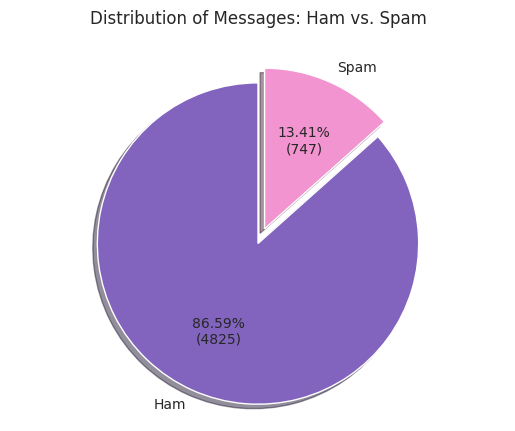

In [18]:
labels = ['Ham', 'Spam']
sizes = df['target'].value_counts()
colors = ['#8264be','#f294d0'] 
explode = (0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct=lambda p: '{:.2f}%\n({:.0f})'.format(p, (p/100)*sizes.sum()),
        shadow=True, startangle=90)
ax1.axis('equal')

plt.title('Distribution of Messages: Ham vs. Spam', pad=20)
plt.show()

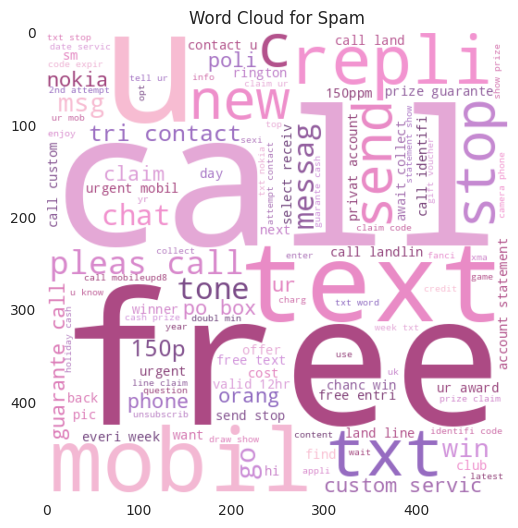

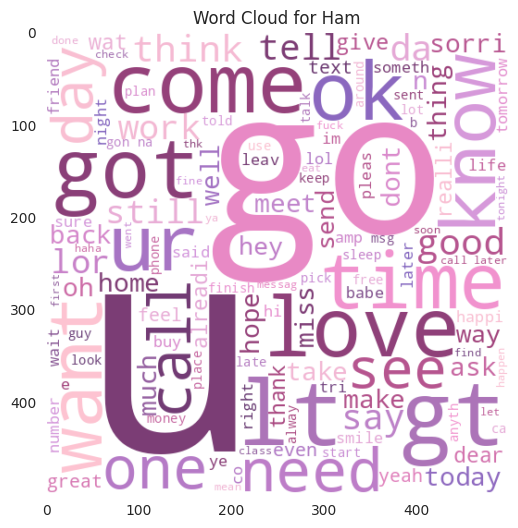

In [19]:
generate_word_clouds(df, 'target', 'transformed_text')

In [20]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)
len(spam_corpus)

ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)
len(ham_corpus)

38122

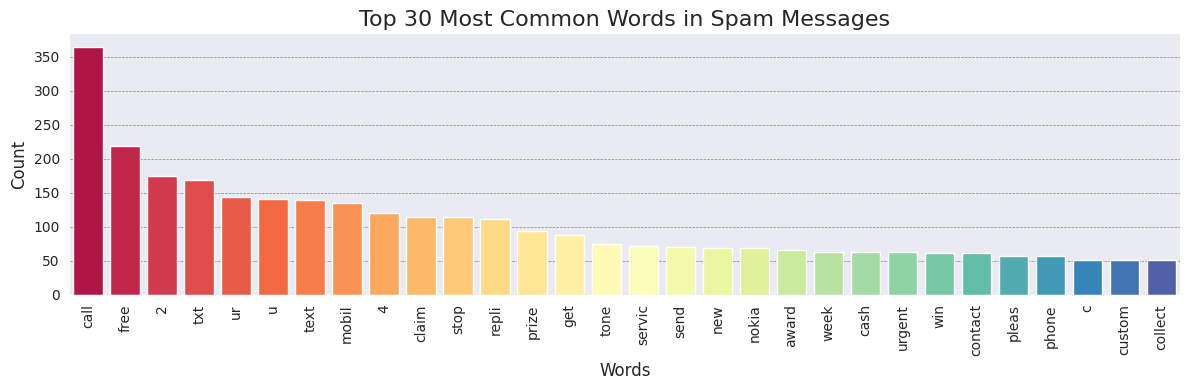

In [21]:
create_rainbow_bar_plot(spam_corpus, 'Top 30 Most Common Words in Spam Messages')

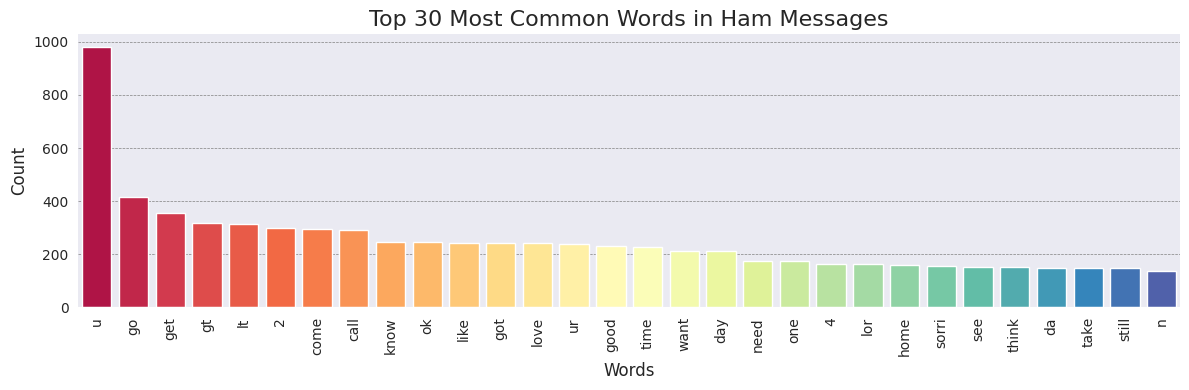

In [22]:
create_rainbow_bar_plot(ham_corpus, 'Top 30 Most Common Words in Ham Messages')

## Set the Parameters for the Models
The parameters for the models are set in the following code. The parameters are set to the default values for each model.

In [23]:
# Split the dataset into training and testing sets
y = df['target']
print (y.value_counts())
 
le = LabelEncoder()
y = le.fit_transform(y)

target
0    4825
1     747
Name: count, dtype: int64


In [24]:
x = x[:len(y)]
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.40, random_state=33)

## Logistic Regression
- The logistic regression model is a simple linear model that is used to predict the probability of a binary outcome. 
- It fits 5 folds each with 10 candidates, totalling 50 fits. The best parameters are then used to train the model.
- The model is then saved as a pickle file for future use in the simulation.

In [26]:
%%time
# Setting up the pipeline with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear', random_state=33, tol=0.01, max_iter=1000))
])

# Parameter grid
param_dist = {
    'logreg__C': np.logspace(-2, 2),
    'logreg__penalty': ['l2']
}

# StratifiedKFold setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_dist, n_iter=10, cv=cv, verbose=1, scoring='accuracy', n_jobs=1, random_state=33)

# Fit the random search to the data
random_search.fit(xtrain, ytrain)

# Output results
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

# Getting the best model
best_model = random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'logreg__penalty': 'l2', 'logreg__C': 0.01}
Best cross-validation score: 0.99
CPU times: user 1min 50s, sys: 56.8 s, total: 2min 47s
Wall time: 1min 52s


Test set accuracy: 0.99
Confusion Matrix:
 [[1928    7]
 [  22  272]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1935
           1       0.97      0.93      0.95       294

    accuracy                           0.99      2229
   macro avg       0.98      0.96      0.97      2229
weighted avg       0.99      0.99      0.99      2229



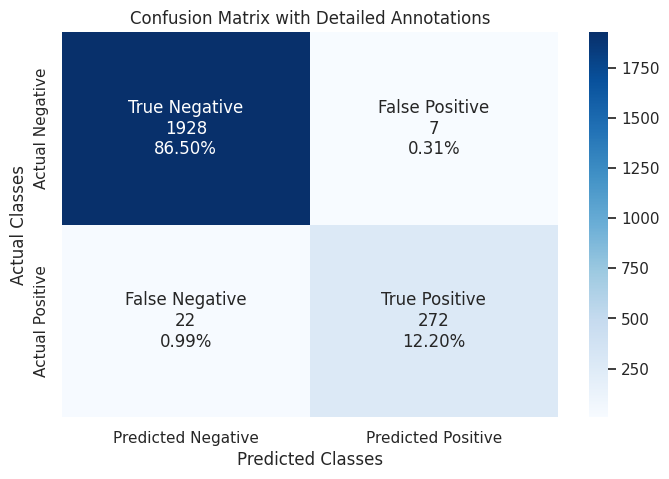

In [27]:
# Display test results and plot confusion matrix
cf_matrix = display_test_results(best_model, xtest, ytest)
plot_confusion_matrix(cf_matrix)

In [28]:
save_model(best_model, 'logistic_regression_model.pkl')

Model saved to logistic_regression_model.pkl


## Naives Bayes

- The Naive Bayes model is a simple probabilistic model that is based on Bayes' theorem.
- It uses Gaussian Naive Bayes to fit the model. The best parameters are then used to train the model.
- The model is then saved as a pickle file for future use in the simulation.

In [29]:
%%time
# Initialise Gaussian Naive Bayes
gnb = GaussianNB()

# Fit the model
gnb.fit(xtrain, ytrain)

# Predictions
ypred = gnb.predict(xtest)

CPU times: user 445 ms, sys: 184 ms, total: 630 ms
Wall time: 628 ms


Test set accuracy: 0.89
Confusion Matrix:
 [[1711  224]
 [  30  264]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93      1935
           1       0.54      0.90      0.68       294

    accuracy                           0.89      2229
   macro avg       0.76      0.89      0.80      2229
weighted avg       0.92      0.89      0.90      2229



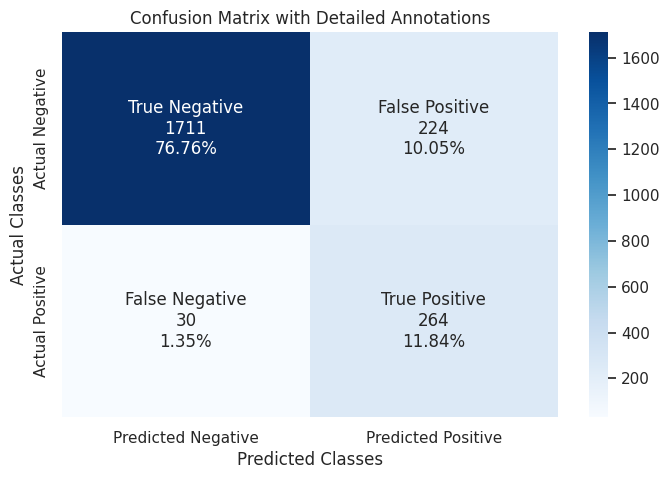

In [30]:
# Display test results and plot confusion matrix
cf_matrix = display_test_results(gnb, xtest, ytest)
plot_confusion_matrix(cf_matrix)

In [31]:
save_model(gnb, 'naive_bayes_model.pkl')

Model saved to naive_bayes_model.pkl


## Random Forest

- The Random Forest model is an ensemble model that is based on decision trees.
- It fits 3 folds each with 18 candidates, totalling 54 fits. The best parameters are then used to train the model.
- The model is then saved as a pickle file for future use in the simulation.

In [32]:
%%time
# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=33)

# Define the parameter grid to tune the model
param_grid = {
    'n_estimators': [10, 50, 100],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2] 
}

# Grid search to find the best parameters
grid = GridSearchCV(rf, param_grid, cv=3, verbose=1, scoring='accuracy', n_jobs=-1)
grid.fit(xtrain, ytrain)

# Output the best parameters and the best score
print("Best parameters:", grid.best_params_)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

# Evaluate the model on the test set using the best parameters
best_model = grid.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.97
CPU times: user 7.99 s, sys: 725 ms, total: 8.72 s
Wall time: 1min 13s


Test set accuracy: 0.89
Confusion Matrix:
 [[1711  224]
 [  30  264]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93      1935
           1       0.54      0.90      0.68       294

    accuracy                           0.89      2229
   macro avg       0.76      0.89      0.80      2229
weighted avg       0.92      0.89      0.90      2229



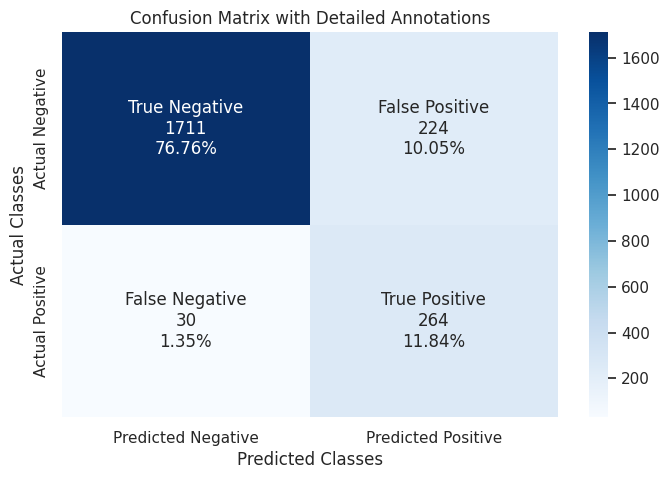

In [33]:
# Display test results and plot confusion matrix
cf_matrix = display_test_results(gnb, xtest, ytest)
plot_confusion_matrix(cf_matrix)

In [34]:
save_model(best_model, 'random_forest_model.pkl')

Model saved to random_forest_model.pkl


## Support Vector Machine

- The Support Vector Machine model is a linear model that is based on the distance between the data points.
- It fits 5 folds each with 10 candidates, totalling 50 fits. The best parameters are then used to train the model.
- The model is then saved as a pickle file for future use in the simulation.

In [35]:
%%time
# Create a pipeline that includes scaling and the SVM classifier
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=33))
])

# Define the parameter grid to tune the SVM model
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'], 
    'svm__gamma': ['scale', 'auto'] 
}

# Grid search to find the best parameters
grid = GridSearchCV(svm_pipeline, param_grid, cv=3, verbose=1, scoring='accuracy', n_jobs=-1)
grid.fit(xtrain, ytrain)

# Output the best parameters and the best score
print("Best parameters:", grid.best_params_)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

# Evaluate the model on the test set using the best parameters
best_model = grid.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best cross-validation score: 0.97
CPU times: user 12.3 s, sys: 1.35 s, total: 13.7 s
Wall time: 5min 12s


Test set accuracy: 0.89
Confusion Matrix:
 [[1711  224]
 [  30  264]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93      1935
           1       0.54      0.90      0.68       294

    accuracy                           0.89      2229
   macro avg       0.76      0.89      0.80      2229
weighted avg       0.92      0.89      0.90      2229



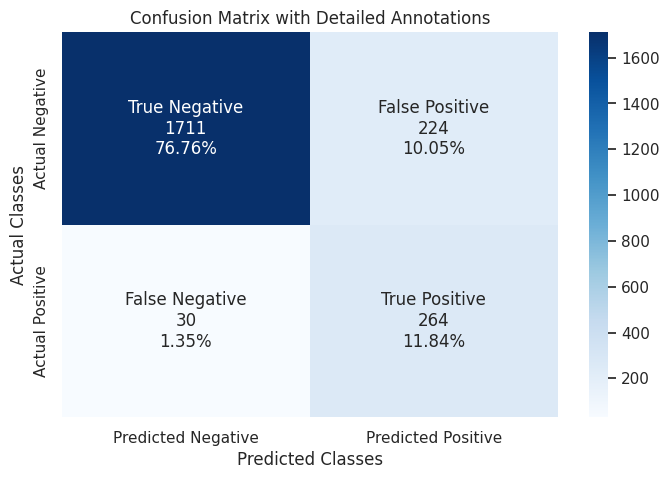

In [36]:
# Display test results and plot confusion matrix
cf_matrix = display_test_results(gnb, xtest, ytest)
plot_confusion_matrix(cf_matrix)

In [37]:
save_model(best_model, 'support_vector_machine_model.pkl')

Model saved to support_vector_machine_model.pkl
